ADSP 32021 ON01 Machine Learning Operations
Student:Aigul Azamat

Assignment 3: AutoML

Sources used:
1. Notebooks from the Discussion Section in Canvas (FLAML_AutoML.ipynb (for Databricks — Questions 1-8); H2O_AutoML.ipynb (for Docker — Question 9))
2. AI tools-Claude.ai was used to assist with code debugging and troubleshooting,technical concept clarification



In [0]:
%pip install flaml[automl] lightgbm

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

Dataset shape: (1000, 11)

Target distribution:
won_medal
0    550
1    450
Name: count, dtype: int64


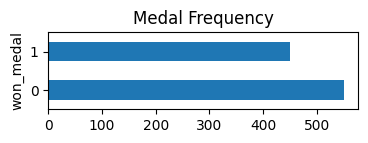

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = spark.table("default.athletes").toPandas()

#binary target
df['won_medal'] = (df['medal'] != 'None').astype(int)

# check for imbalancy 
df['won_medal'].value_counts().plot(kind='barh', figsize=(4, 1), title='Medal Frequency')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['won_medal'].value_counts())

In [0]:
#Split features and label
# drop non-feature columns
X = df.drop(['won_medal', 'medal', 'name', 'athlete_id'], axis=1)
y = df['won_medal']

# encode categoricals for FLAML
from sklearn.preprocessing import LabelEncoder

cat_cols = X.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns: {cat_cols}")

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nFeatures: {list(X.columns)}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Categorical columns: ['country', 'sport']

Features: ['age', 'height', 'weight', 'country', 'sport', 'years_experience', 'training_hours_per_week']
Training set: (800, 7)
Test set: (200, 7)


In [0]:
# FLAML AutoML - ALL features
from flaml import AutoML

model_config = {
    'task': 'classification',
    'time_budget': 120,
    'metric': 'f1',
    'estimator_list': ['lgbm', 'xgboost', 'rf', 'extra_tree', 'lrl1', 'kneighbor'],
    'eval_method': 'cv',
    'split_type': 'stratified',
    'seed': 42,
    'verbose': 3,
    'log_file_name': 'flaml_all_features_log'
}

model_all = AutoML()
model_all.fit(X_train, y_train, **model_config)

Tried to attach usage logger `pyspark.databricks.pandas.usage_logger`, but an exception was raised: JVM wasn't initialised. Did you call it on executor side?


[flaml.automl.logger: 02-16 02:02:55] {2375} INFO - task = classification
[flaml.automl.logger: 02-16 02:02:55] {2386} INFO - Evaluation method: cv
[flaml.automl.logger: 02-16 02:02:55] {2489} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 02-16 02:02:55] {2606} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree', 'lrl1', 'kneighbor']
[flaml.automl.logger: 02-16 02:02:55] {2911} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-16 02:02:56] {3046} INFO - Estimated sufficient time budget=1518s. Estimated necessary time budget=30s.
[flaml.automl.logger: 02-16 02:02:57] {3097} INFO -  at 1.0s,	estimator lgbm's best error=9.2663e-01,	best estimator lgbm's best error=9.2663e-01
[flaml.automl.logger: 02-16 02:02:57] {2911} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-16 02:02:57] {3097} INFO -  at 2.2s,	estimator lgbm's best error=9.2663e-01,	best estimator lgbm's best error=9.2663e-01
[flaml.automl.logger: 02-16 0

In [0]:
# best Model / Estimator
print(model_all.model.estimator)

# best hyperparameter of each estimator
print(model_all.best_config_per_estimator)

# best iteration
print(f"\nThe {model_all.best_iteration}-th iteration is the best, completed in {round(model_all.time_to_find_best_model, 1)} seconds.")

# predict and evaluate
y_test_pred_all = model_all.predict(X_test)
print(classification_report(y_test, y_test_pred_all))

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')
{'lgbm': {'n_estimators': 9, 'num_leaves': 31, 'min_child_samples': 9, 'learning_rate': np.float64(0.619857605629445), 'log_max_bin': 7, 'colsample_bytree': np.float64(0.9743381896390885), 'reg_alpha': np.float64(0.0036961332109982934), 'reg_lambda': np.float64(0.0790587009476188)}, 'xgboost': {'n_estimators': 8, 'max_leaves': 19, 'min_child_weight': np.float64(0.0514027127114294), 'learning_rate': 1.0, 'subsample': np.float64(0.5148796675791588), 'colsample_bylevel': 1.0, 'colsample_bytree': np.float64(0.7116613423283833), 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(0.5386699986557016)}, 'rf': {'n_estimators': 13, 'max_features': np.float64(0.8931208898292718), 'max_leaves': 137, 'criterion': np.str_('gini')}, 'extra_tree': {'n_estimators': 17, 'max_features': np.float64(0.5073955791839285), 'max_leaves': 399, 'criterion': np.str_('gini')}, 'lrl1': {'C': np.float64(3.9999999999999987)}, 'kneighbor': {'n_neighbo

Best algorithm: kneighbor
Best validation F1: 0.5032
Time to find best model: 26.7 sec
Total iterations: 121
Top 5 features:
#1: weight (importance: 0.0572)
#2: training_hours_per_week (importance: 0.0316)
#3: age (importance: 0.0246)
#4: country (importance: 0.0144)
#5: height (importance: 0.0137)


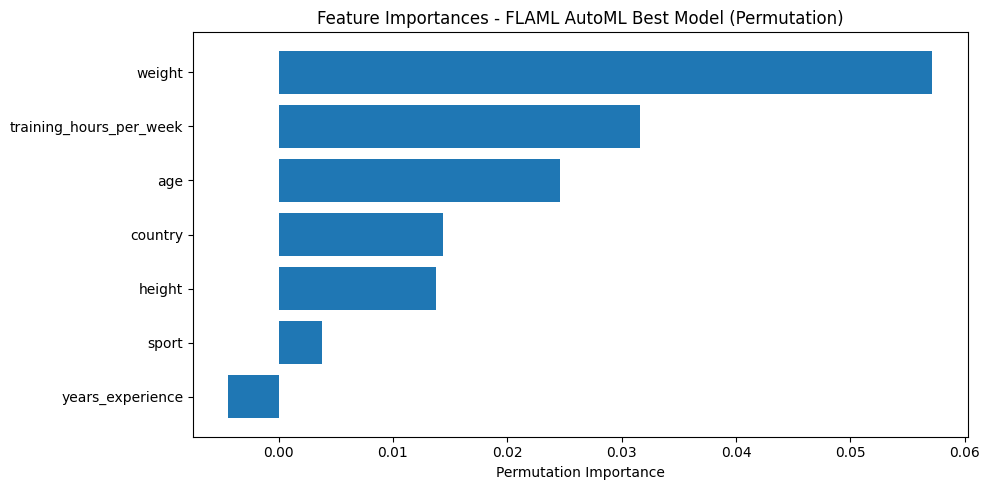


Top 5 features: ['weight', 'training_hours_per_week', 'age', 'country', 'height']


In [0]:
#Data insights and top 5 features
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

print(f"Best algorithm: {model_all.best_estimator}")
print(f"Best validation F1: {1 - model_all.best_loss:.4f}")
print(f"Time to find best model: {round(model_all.time_to_find_best_model, 1)} sec")
print(f"Total iterations: {model_all.best_iteration}")
print("Top 5 features:")

feature_names = X_train.columns.tolist()

#permutation importance (works for all model types including KNN)
perm_result = permutation_importance(
    model_all.model.estimator, X_test, y_test, 
    n_repeats=10, random_state=42, scoring='f1'
)
importances = perm_result.importances_mean

indices = np.argsort(importances)[::-1]


top_features = []
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"#{i+1}: {feature_names[idx]} (importance: {importances[idx]:.4f})")
    top_features.append(feature_names[idx])

# Plot
plt.figure(figsize=(10, 5))
sorted_idx = np.argsort(importances)
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importances - FLAML AutoML Best Model (Permutation)")
plt.tight_layout()
plt.show()

print(f"\nTop 5 features: {top_features}")

In [0]:
#Top 3 models by validation score and speed - all features
from flaml.automl.data import get_output_from_log
import json

# read results from FLAML log file
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='flaml_all_features_log', time_budget=120)

estimator_results = {}
for i, config in enumerate(config_history):
    estimator = config.get('Current Learner', 'unknown')
    val_f1 = 1 - valid_loss_history[i]
    train_time = time_history[i]
    
    #best result per estimator
    if estimator not in estimator_results or val_f1 > estimator_results[estimator]['val_f1']:
        estimator_results[estimator] = {
            'estimator': estimator,
            'val_f1': round(val_f1, 4),
            'train_time': round(train_time, 2)
        }

all_results = list(estimator_results.values())

print("Q5a: Top 3 Models by Validation Score (all features)")
sorted_by_score = sorted(all_results, key=lambda x: x["val_f1"], reverse=True)
for i, r in enumerate(sorted_by_score[:3]):
    print(f"\n#{i+1}: {r['estimator']}")
    print(f"    Validation F1: {r['val_f1']}")
    print(f"    Training Time: {r['train_time']} sec")

print("Q6a: Top 3 Models by Speed (all features)")
sorted_by_speed = sorted(all_results, key=lambda x: x["train_time"])
for i, r in enumerate(sorted_by_speed[:3]):
    print(f"\n#{i+1}: {r['estimator']}")
    print(f"    Training Time: {r['train_time']} sec")
    print(f"    Validation F1: {r['val_f1']}")

print(f"\n\nTotal estimators tried: {len(all_results)}")
print(f"All estimators: {[r['estimator'] for r in sorted_by_score]}")

Q5a: Top 3 Models by Validation Score (all features)

#1: kneighbor
    Validation F1: 0.5032
    Training Time: 26.67 sec

#2: lgbm
    Validation F1: 0.502
    Training Time: 11.73 sec
Q6a: Top 3 Models by Speed (all features)

#1: lgbm
    Training Time: 11.73 sec
    Validation F1: 0.502

#2: kneighbor
    Training Time: 26.67 sec
    Validation F1: 0.5032


Total estimators tried: 2
All estimators: ['kneighbor', 'lgbm']


In [0]:
# FLAML AutoML 
top_3 = top_features[:3]
print(f"Running AutoML with top 3 features: {top_3}\n")

X_train_top = X_train[top_3]
X_test_top = X_test[top_3]

model_config_top = {
    'task': 'classification',
    'time_budget': 120,
    'metric': 'f1',
    'estimator_list': ['lgbm', 'xgboost', 'rf', 'extra_tree', 'lrl1', 'kneighbor'],
    'eval_method': 'cv',
    'split_type': 'stratified',
    'seed': 42,
    'verbose': 3,
    'log_file_name': 'flaml_top_features_log'
}

model_top = AutoML()
model_top.fit(X_train_top, y_train, **model_config_top)

Running AutoML with top 3 features: ['weight', 'training_hours_per_week', 'age']

[flaml.automl.logger: 02-16 02:06:20] {2375} INFO - task = classification
[flaml.automl.logger: 02-16 02:06:20] {2386} INFO - Evaluation method: cv
[flaml.automl.logger: 02-16 02:06:20] {2489} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 02-16 02:06:20] {2606} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree', 'lrl1', 'kneighbor']
[flaml.automl.logger: 02-16 02:06:20] {2911} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-16 02:06:20] {3046} INFO - Estimated sufficient time budget=807s. Estimated necessary time budget=16s.
[flaml.automl.logger: 02-16 02:06:20] {3097} INFO -  at 0.2s,	estimator lgbm's best error=9.5862e-01,	best estimator lgbm's best error=9.5862e-01
[flaml.automl.logger: 02-16 02:06:20] {2911} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-16 02:06:20] {3097} INFO -  at 0.3s,	estimator lgbm's best error=9.58

In [0]:
from flaml.automl.data import get_output_from_log

# Best model info
print(model_top.model.estimator)
print(f"\nThe {model_top.best_iteration}-th iteration is the best, completed in {round(model_top.time_to_find_best_model, 1)} seconds.")

# evaluate
y_test_pred_top = model_top.predict(X_test_top)
print(classification_report(y_test, y_test_pred_top))

# read from log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='flaml_top_features_log', time_budget=120)

estimator_results_top = {}
for i, config in enumerate(config_history):
    estimator = config.get('Current Learner', 'unknown')
    val_f1 = 1 - valid_loss_history[i]
    train_time = time_history[i]
    
    if estimator not in estimator_results_top or val_f1 > estimator_results_top[estimator]['val_f1']:
        estimator_results_top[estimator] = {
            'estimator': estimator,
            'val_f1': round(val_f1, 4),
            'train_time': round(train_time, 2)
        }

all_results_top = list(estimator_results_top.values())

# Top 3 by score
print("Q5b: Top 3 Models by Validation Score (Top 3 features)")
sorted_top_score = sorted(all_results_top, key=lambda x: x["val_f1"], reverse=True)
for i, r in enumerate(sorted_top_score[:3]):
    print(f"#{i+1}: {r['estimator']} | F1: {r['val_f1']} | Time: {r['train_time']} sec")

# Top 3 by speed
print("Q6b: Top 3 Models by Speed (Top 3 features)")
sorted_top_speed = sorted(all_results_top, key=lambda x: x["train_time"])
for i, r in enumerate(sorted_top_speed[:3]):
    print(f"#{i+1}: {r['estimator']} | Time: {r['train_time']} sec | F1: {r['val_f1']}")

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=np.float64(0.9258377180082863),
              colsample_bynode=None,
              colsample_bytree=np.float64(0.893832019915574), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=88,
              min_child_weight=np.float64(0.027450247833248495), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=46,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

The 396-th iteration is the best, completed in 110.9 seconds.
              precision    recall  f1-score   support

           0       0.5

In [0]:
#Q7. Compare with Assignment 1 and Q8. Platform Assessment
from sklearn.metrics import f1_score, accuracy_score

# assignment 1 results
manual_f1 = 0.4294
manual_acc = 0.535

# AutoML test results
y_test_pred_all = model_all.predict(X_test)
test_f1_all = f1_score(y_test, y_test_pred_all)
test_f1_top = f1_score(y_test, y_test_pred_top)
test_acc_all = accuracy_score(y_test, y_test_pred_all)
test_acc_top = accuracy_score(y_test, y_test_pred_top)

print(f"\n{'Model':<35} {'Test F1':<12} {'Test Acc':<12} {'Best Estimator':<20}")
print("-" * 60)
print(f"{'Assignment 1 (Manual RF)':<35} {manual_f1:<12.4f} {manual_acc:<12.4f} {'RandomForest':<20}")
print(f"{'FLAML AutoML (All Features)':<35} {test_f1_all:<12.4f} {test_acc_all:<12.4f} {model_all.best_estimator:<20}")
print(f"{'FLAML AutoML (Top 3 Features)':<35} {test_f1_top:<12.4f} {test_acc_top:<12.4f} {model_top.best_estimator:<20}")

improvement = ((test_f1_all - manual_f1) / manual_f1) * 100
print(f"\nAutoML F1 improvement over manual: {improvement:+.1f}%")


Model                               Test F1      Test Acc     Best Estimator      
------------------------------------------------------------
Assignment 1 (Manual RF)            0.4294       0.5350       RandomForest        
FLAML AutoML (All Features)         0.4868       0.5150       kneighbor           
FLAML AutoML (Top 3 Features)       0.4693       0.5250       xgboost             

AutoML F1 improvement over manual: +13.4%


### Q8: Is your platform AutoML no-code / low-code / full-code?

FLAML on Databricks Community Edition is **FULL-CODE** because:

1. FLAML is the engine behind Databricks AutoML
2. In Community Edition, we use it via Python API (full code)
3. We write code to: configure search space, set metrics, define estimators
4. We code the data loading, preprocessing, and evaluation ourselves
5. Results extraction requires code (log parsing, config history)
6. No drag-and-drop UI or visual interface available

**Note:** Paid Databricks offers a LOW-CODE AutoML UI that wraps FLAML, but in Community Edition it is fully code-driven.

**Scale:**
- **No-code:** 100% UI, zero programming (e.g., Google AutoML Tables UI)
- **Low-code:** Minimal code, mostly UI (e.g., Databricks paid AutoML UI)
- **Full-code:** All code, no UI (e.g., FLAML API, H2O Python API)